### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

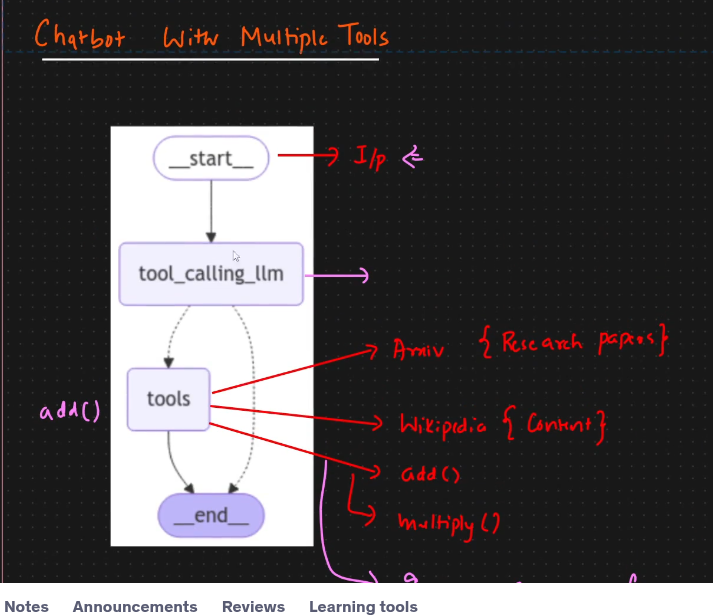

In [1]:
# Import tools and utilities
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [4]:
# Here we initialize the wrapper and query
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
# Here we test running against the API
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
# Here we do the same for Wikipedia
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
# Here we run it
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [9]:
# Here we load the environment variables
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [10]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

/tmp/ipykernel_60471/637379855.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [11]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Daily News March 03 2025: Nvidia CEO - Apple Podcasts',
  'url': 'https://podcasts.apple.com/ca/podcast/ai-daily-news-march-03-2025-nvidia-ceo-us-ai-chips/id1684415169?i=1000697521476',
  'content': "AI Unraveled: Latest AI News & Trends, ChatGPT, Gemini, DeepSeek, Gen AI, LLMs, AI Ethics & Bias\n\n# AI Daily News March 03 2025: ð\x9f\x9a\x80 Nvidia CEO: US AI Chips Are 60x Faster Than Chinaâ\x80\x99s ð\x9f\x8d\x8fApple's Siri Overhaul Facing Major Delays ð\x9f\x8e\x99ï¸\x8fNew AI Voice to Cross â\x80\x98Uncanny Valleyâ\x80\x99 ð\x9f\x8e¥Sora Video AI Coming to ChatGPT ð\x9f§ªAI Detects Colorect [...] Nvidia claims a significant lead in AI chip speed over China, while Apple faces delays in its Siri AI overhaul. New AI applications are emerging, including highly realistic voice generation, automated resume screening, and AI cardiologists in China.OpenAI plans to integrate Sora video AI into ChatGPT, and large investments are being made in AI by companies like Honor and So

In [12]:
### Combine all the tools in the list
tools=[arxiv,wiki,tavily]

In [18]:
## Initialize my LLM model
from langchain_groq import ChatGroq

# Initialized the llm
llm=ChatGroq(model="qwen/qwen3-32b")

# Bind the tools
llm_with_tools=llm.bind_tools(tools)

In [19]:
# Here we invoke the llm w/ tools
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, which is for scientific papers in fields like Physics and Computer Science. But the user is asking for news, not research papers. So maybe arxiv isn\'t the best fit here.\n\nNext, the wikipedia function. Wikipedia does have information on AI, but it\'s more of a general knowledge encyclopedia. Recent news might not be covered there immediately. Plus, Wikipedia entries are more about established information rather than the latest updates.\n\nThen there\'s the tavily_search_results_json function, which is described as a search engine for comprehensive and current results. Since the user wants recent news, this seems like the right choice. Tavily is optimized for current events, so it should provide the latest AI news articles.\n\nI should confirm if there are an

In [20]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '87h84zxdp',
  'type': 'tool_call'}]

In [21]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

# Intialize the State
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

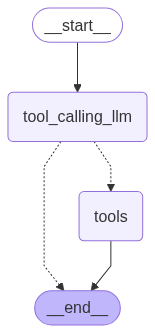

In [22]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
## Add Nodes
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [24]:
# Notice that it pulled the arxiv information based on the reference number of he book
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (f5p38tae0)
 Call ID: f5p38tae0
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [ ]:
# Here is another example
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vfzn)
 Call ID: call_vfzn
  Args:
    query: top 10 recent AI news for March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@abhishekmonpara198/weekly-tech-talk-march-3rd-2025-stay-informed-about-the-most-recent-updates-in-the-industry-4d0f4519891d", "content": "A startup, Akool, upgrades Akool Streaming Avatars by connecting them with AI models and adding advanced video generation tech integrating with large language models (LLMs). According to recently published data from Chinese AI provider Deepseek, AI language models have the potential to generate significant profit margins, even when priced well below that of OpenA

In [22]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_31ew)
 Call ID: call_31ew
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
